In [1]:
%matplotlib inline

import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples
from chainer.datasets import TupleDataset
from chainer.functions.evaluation import accuracy
from chainer.functions.loss import softmax_cross_entropy
from chainer import link
from chainer import reporter

import matplotlib.pyplot as plt

global HIDDEN_UNITS
HIDDEN_UNITS = 3

In [2]:
# create toy data - compute sum of the previous and current input
def create_data(n=3000):

    X = np.random.rand(n,1).astype('float32')
    T = np.sum(np.hstack((X[0:-1],X[1:])),axis=1)
    T = np.hstack([0, T[0:]]).astype('float32')
    T = T.reshape([n,1])

    return TupleDataset(X, T)

In [83]:
class RNN(Chain):
    def __init__(self):
        super(RNN, self).__init__()
        with self.init_scope():
            self.l1 = L.LSTM(None, HIDDEN_UNITS)
            self.out = L.Linear(None, 1)
            
    def reset_state(self):
        self.l1.reset_state()
        
    def __call__(self, x):
        h1 = self.l1(x)
        y = self.out(h1)
        return y

In [86]:
class Regressor(link.Chain):

    compute_accuracy = False

    def __init__(self, predictor,
                 lossfun=softmax_cross_entropy.softmax_cross_entropy,
                 accfun=accuracy.accuracy,
                 label_key=-1):
        if not (isinstance(label_key, (int, str))):
            raise TypeError('label_key must be int or str, but is %s' %
                            type(label_key))

        super(Regressor, self).__init__()
        self.lossfun = lossfun
        self.accfun = accfun
        self.y = None
        self.loss = None
        self.accuracy = None
        self.label_key = label_key

        with self.init_scope():
            self.predictor = predictor

    def __call__(self, *args, **kwargs):

        if isinstance(self.label_key, int):
            if not (-len(args) <= self.label_key < len(args)):
                msg = 'Label key %d is out of bounds' % self.label_key
                raise ValueError(msg)
            t = args[self.label_key]
            if self.label_key == -1:
                args = args[:-1]
            else:
                args = args[:self.label_key] + args[self.label_key + 1:]
        elif isinstance(self.label_key, str):
            if self.label_key not in kwargs:
                msg = 'Label key "%s" is not found' % self.label_key
                raise ValueError(msg)
            t = kwargs[self.label_key]
            del kwargs[self.label_key]

        self.y = None
        self.loss = None
        self.accuracy = None
        self.y = self.predictor(*args, **kwargs)
        self.loss = self.lossfun(self.y, t)
        reporter.report({'loss': self.loss}, self)
        return self.loss

In [85]:
class Iterator():

    def __init__(self, data):
        self.data = data
        self.done = False
        self.count = 0
        
    def next_batch(self):
        # go on
        if not self.is_done():
            number = np.array([[self.data[self.count][0]]])
            label = np.array([[self.data[self.count][1]]])
            self.count += 1
            return number, label
                    
    def is_done(self):
        return self.count == len(self.data)-1

In [78]:
def compute_loss(data, regressor):
    loss = 0
    losses = []
    for row in data:
        number = np.array([row[0]])
        label = np.array([row[1]])
        add_loss = regressor(number, label)
        loss += add_loss
        losses.append(loss.data)
    return loss, losses

In [115]:
def compute_predictions(data, model):
    preds = []
    for row in data:
        pred = model(np.array([[row[0]]])).data
        preds.append(pred[0][0])
    return preds

In [140]:
def get_labels(data):
    labels = []
    for row in data:
        label = row[0][0]
        labels.append(label)
    return labels

In [141]:
def run(train_iter, val_iter, test_data, network, regressor, optimizer, max_epoch):
    training_losses = []
    validation_losses = []
    
    mini_batch_losses = []

    while not train_iter.is_done():
        # Get next mini-batch
        data, label = train_iter.next_batch()
        #image_train, target_train = concat_examples(batch)
        
        # Prediction
        print("make pred")
        prediction_train = network(data)
        
        # Reset state of the network
        print("reset")
        network.reset_state()
        regressor.cleargrads()

        # Compute loss
        print("make loss")
        loss = regressor(prediction_train, label)
        mini_batch_losses.append(loss.data)

        # Compute gradients
        print("clear grads")
        loss.backward()

        # Update variables
        optimizer.update()

        

    # Predict full test set
    image_test, target_test = concat_examples(test_data)
    # Forward test data
    prediction_test = network(image_test)
    # Calculate loss and accuracy
    loss_test = regressor(prediction_test, target_test)

    print('test_loss: ' + str(loss_test.data))
    return training_losses, validation_losses

In [142]:
def run2(network, regressor, optimizer, train_data, test_data):
    network.reset_state()
    regressor.cleargrads()

    loss_train, losses_train = compute_loss(train_data, regressor)
    print('training_loss: ' + str(loss_train.data))
    
    loss_train.backward()
    optimizer.update()
    
    # Calculate loss and accuracy
    network.reset_state()
    regressor.cleargrads()
    loss_test, losses_test = compute_loss(test_data, regressor)

    print('test_loss: ' + str(loss_test.data))
    return losses_train, losses_test

training_loss: 5260.26367188
test_loss: 37341916.0


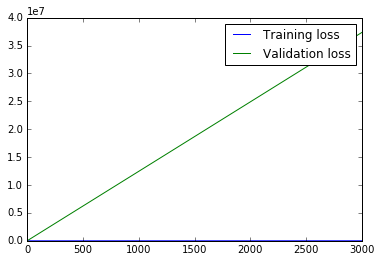

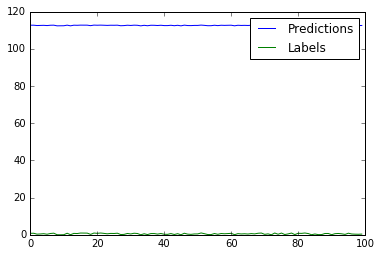

In [143]:
def main():
    # Create data
    train_data = create_data()
    test_data = create_data()

    # Define model
    network = RNN()
    regressor = Regressor(network, F.mean_squared_error)
    optimizer = optimizers.SGD()
    optimizer.setup(regressor)
    
    losses_train, losses_test = run2(network, regressor, optimizer, train_data, test_data)
    
    plt.figure(1)
    plt.plot(losses_train, label='Training loss')
    plt.plot(losses_test, label='Validation loss')
    plt.legend()
    
    plt.figure(2)
    preds100 = compute_predictions(test_data[:100], network)
    labels100 = get_labels(test_data[:100])
    plt.plot(preds100, label="Predictions")
    plt.plot(labels100, label="Labels")
    plt.legend()

if __name__ == "__main__":
    main()

In [40]:
train = create_data()
train[2999][0]

array([ 0.78321761], dtype=float32)

### Sources
https://docs.chainer.org/en/stable/tutorial/recurrentnet.html